<a href="https://colab.research.google.com/github/chineidu/NLP-Tutorial/blob/main/notebook/Projects/Search/Hybrid-search/01-e-commerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# E-Commerce Hybrid Search

- Hybrid search is an information retrieval technique that combines multiple search algorithms to improve the accuracy and relevance of search results.
- It leverages the strengths of different approaches to overcome the limitations of each individually.

## Traditional Search Methods

- **Keyword-based search**: Relies on **matching keywords** in the query to keywords in documents. It's efficient but often misses semantically similar content.
- **Semantic search**: Uses **vector representations** (embeddings) to capture the **meaning of text**, allowing for retrieval based on semantic similarity. It can be less efficient for large datasets.

## Hybrid Search Approach

- It combines keyword and semantic search: Utilizes keywords for initial filtering and semantic similarity for deeper analysis.
- It provides results that are both semantically relevant and contain the query keywords.
- It offers a more intuitive and natural search experience.

## Implementation

- **Pinecone's** `sparse-dense` index allows us to perform seamless hybrid search for e-commerce or in any other context.

In [1]:
# !pip install -qU transformers[torch] datasets evaluate \
#                 sentence-transformers pinecone-client pinecone-text \
#                 protobuf python-dotenv

In [2]:
# Built-in library
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard importsa
import numpy as np
from pathlib import Path
import pandas as pd
import polars as pl
from pprint import pprint
from rich import print
import torch

# Visualization
import matplotlib.pyplot as plt


# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

warnings.filterwarnings("ignore")

# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [3]:
import os

from dotenv import load_dotenv, find_dotenv


load_dotenv(dotenv_path=find_dotenv(filename=".env"))


def load_creds() -> tuple[Optional[str], Optional[str], Optional[str], Optional[str]]:
    """This is used to load the credentials."""
    OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
    PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
    PINECONE_ENV = os.getenv("PINECONE_ENV")
    QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")

    return (OPENAI_API_KEY, PINECONE_API_KEY, PINECONE_ENV, QDRANT_API_KEY)


(OPENAI_API_KEY, PINECONE_API_KEY, PINECONE_ENV, QDRANT_API_KEY) = load_creds()

In [4]:
from getpass import getpass


RUN_CELL: bool = False

if RUN_CELL:
    # Get API key without displaying it
    PINECONE_API_KEY: str = getpass("Please enter your API key: ")
    PINECONE_ENV: str = "us-west4-gcp-free"

## Initialize Connection To Pinecone

In [5]:
import pinecone


pinecone.init(api_key=PINECONE_API_KEY, environment=PINECONE_ENV)

### Note

- To use the `sparse-dense` index in `Pinecone`, we must set the `metri="dotproduct"` and use either `s1` or `p1` pods.

In [6]:
INDEX_NAME: str = "hybrid-image-search"
VECTOR_DIMENSION: int = 512
METRIC: str = "dotproduct"
POD_TYPE: str = "s1"

# Create index
if INDEX_NAME not in pinecone.list_indexes():
    pinecone.create_index(
        name=INDEX_NAME,
        dimension=VECTOR_DIMENSION,
        metric=METRIC,
        pod_type=POD_TYPE,
    )

# Connect to the Pinecone index
index = pinecone.Index(index_name=INDEX_NAME)

## Load Data

- We'll be using a subset of the Open Fashion Product Images dataset which contains ~44k fashion products with images.
- The data can be found on [kaggle](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small).
- It can also be found here on [HuggingFace](https://huggingface.co/datasets/ashraq/fashion-product-images-small).

In [7]:
from datasets import Dataset, load_dataset


PATH: str = "ashraq/fashion-product-images-small"
SPLIT: str = "train"

fashion_data: Dataset = load_dataset(path=PATH, split=SPLIT)

fashion_data

Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 44072
})

In [8]:
# Extract the images and create the metadata/payload
images: list[Any] = fashion_data["image"]
metadata: Dataset = fashion_data.remove_columns(column_names=["image"])

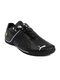

In [9]:
# Display a product
images[10]

In [10]:
# Convert metadata to a DataFrame
metadata: pd.DataFrame = metadata.to_pandas()
metadata.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [11]:
# Concatenate the data to create product description
# Sample
A: pd.DataFrame = metadata.iloc[:3]

COLUMNS: list[str] = [
    "gender",
    "masterCategory",
    "subCategory",
    "articleType",
    "baseColour",
    "season",
    "usage",
    "productDisplayName",
]
A[COLUMNS].agg(" ".join, axis=1)

0     Men Apparel Topwear Shirts Navy Blue Fall Casual Turtle Check Men Navy Blue Shirt
1    Men Apparel Bottomwear Jeans Blue Summer Casual Peter England Men Party Blue Jeans
2       Women Accessories Watches Watches Silver Winter Casual Titan Women Silver Watch
dtype: object

In [12]:
metadata = metadata.assign(productDetails=lambda df: df[COLUMNS].agg(" ".join, axis=1))

metadata.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,productDetails
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,Men Apparel Topwear Shirts Navy Blue Fall Casual Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,Men Apparel Bottomwear Jeans Blue Summer Casual Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,Women Accessories Watches Watches Silver Winter Casual Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,Men Apparel Bottomwear Track Pants Black Fall Casual Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,Men Apparel Topwear Tshirts Grey Summer Casual Puma Men Grey T-shirt


<br>

## Sparse Vectors

- Sparse vectors are vectors with too many zero values.

### BM25

- `BM25` (Best Matching 25) is a `ranking function` used in information retrieval systems, particularly search engines, to estimate the relevance of documents to a given search query.
- It is a `bag-of-words` model, meaning it considers the `occurrence of individual terms` in documents without regard to their order or proximity.

- Create a `sparse` using the `BM25` algorithm which has been implemented by `Pinecone-text`

```sh
pip install "pinecone-text[splade]"
```

In [13]:
from pinecone_text.sparse import BM25Encoder


bm25: BM25Encoder = BM25Encoder()
bm25

In [14]:
# Train the encoder
bm25.fit(corpus=metadata["productDetails"])

  0%|          | 0/44072 [00:00<?, ?it/s]

In [15]:
query: str = metadata["productDetails"].iloc[0]
query

'Men Apparel Topwear Shirts Navy Blue Fall Casual Turtle Check Men Navy Blue Shirt'

In [16]:
bm25.encode_queries(texts=query)

{'indices': [632192512,
  1540502846,
  2795873812,
  3828986392,
  931643408,
  3905155331,
  453950983,
  4127429595,
  23789636,
  1830646559],
 'values': [0.033226775453346284,
  0.0349051016114858,
  0.05072705308188816,
  0.12594198072251944,
  0.15018442794166703,
  0.08668186009595047,
  0.06510033533293173,
  0.011811300452238377,
  0.2773844203738264,
  0.16403674493414636]}

In [17]:
# Calculate the IDF which is what will be stored in the Pinecone VectorDB
bm25.encode_documents(texts=query)

{'indices': [632192512,
  1540502846,
  2795873812,
  3828986392,
  931643408,
  3905155331,
  453950983,
  4127429595,
  23789636,
  1830646559],
 'values': [0.6127809658942706,
  0.44173338948546054,
  0.44173338948546054,
  0.6127809658942706,
  0.6127809658942706,
  0.6127809658942706,
  0.44173338948546054,
  0.44173338948546054,
  0.44173338948546054,
  0.44173338948546054]}

<br><hr>

### OpenAI's Clip Model

- **CLIP (Contrastive Language-Image Pre-Training)** is a neural network trained on a variety of (image, text) pairs.

- It can be instructed in natural language to predict the most relevant text snippet, given an image, without directly optimizing for the task, similarly to the zero-shot capabilities of GPT-2 and 3.

- For our usecase, it comverts images into embeddings.

In [18]:
# Load Clip model from HuggingFace
from sentence_transformers import SentenceTransformer


device: str = "cuda" if torch.cuda.is_available else "cpu"
MODEL_CHECKPOINT: str = "clip-ViT-B-16"

# Load CLIP model
model: SentenceTransformer = SentenceTransformer(MODEL_CHECKPOINT)
model

2023-12-10 16:10:48.440783: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


SentenceTransformer(
  (0): CLIPModel()
)

In [19]:
# Shape of embeddings
model.encode(sentences=[query]).shape

(1, 512)

## Upsert The Data

- Generate `sparse` and `dense` vectors and upsert the data into the `Pinecone` index.

In [20]:
from tqdm.auto import tqdm


if RUN_CELL:
    BATCH_SIZE: int = 128

    for i in tqdm(range(0, len(fashion_data), BATCH_SIZE)):
        # Find end of batch
        i_end = min(i + BATCH_SIZE, len(fashion_data))

        # Extract metadata batch
        meta_batch = metadata[["productDetails"]]
        meta_batch = meta_batch.iloc[i:i_end]
        meta_dict = meta_batch.to_dict(orient="records")

        # Extract image batch
        img_batch = images[i:i_end]
        # Create sparse BM25 vectors
        sparse_embeds = bm25.encode_documents(
            [text.get("productDetails") for text in meta_dict]
        )
        # Create dense vectors
        dense_embeds = model.encode(img_batch).tolist()
        # Create unique IDs
        ids = [str(x) for x in range(i, i_end)]

        upserts = []
        # Loop through the data and create dictionaries for uploading documents to pinecone index
        for _id, sparse, dense, meta in zip(
            ids, sparse_embeds, dense_embeds, meta_dict
        ):
            upserts.append(
                {"id": _id, "sparse_values": sparse, "values": dense, "metadata": meta}
            )
        # Upload the documents to the new hybrid index
        index.upsert(upserts)

print(">>> DONE !!! <<<")

>>> DONE !!! <<<

In [21]:
# Show index description after uploading the documents
index.describe_index_stats()

{'dimension': 512,
 'index_fullness': 0.2,
 'namespaces': {'': {'vector_count': 44072}},
 'total_vector_count': 44072}

<br>

### Query The VectorDB

In [22]:
N: int = 10
query: str = "dark blue french connection jeans for men"

# Create sparse and dense vectors
sparse_vector: dict[str, Any] = bm25.encode_queries(texts=query)
dense_vector: list[float] = model.encode(sentences=query).tolist()

result = index.query(
    vector=dense_vector, sparse_vector=sparse_vector, include_metadata=True, top_k=N
)

In [23]:
print(result)

{'matches': [{'id': '17695',
              'metadata': {'productDetails': 'Men Apparel Bottomwear Jeans '
                                             'Blue Fall Casual John Players '
                                             'Men Blue Jeans'},
              'score': 29.229,
              'values': []},
             {'id': '1408',
              'metadata': {'productDetails': 'Men Apparel Bottomwear Jeans '
                                             'Navy Blue Summer Casual Lee '
                                             'Rinse Navy Blue Slim Fit Jeans'},
              'score': 28.0164604,
              'values': []},
             {'id': '37096',
              'metadata': {'productDetails': 'Men Apparel Topwear Tshirts Grey '
                                             'Spring Casual Probase Men Stripe '
                                             'Grey T-shirt'},
              'score': 27.9220829,
              'values': []},
             {'id': '40340',
              'metadata': {'productDetails': 'Men Apparel Bottomwear Jeans '
                                             'Blue Summer Casual Jack & Jones '
                                             'Men Blue Jeans'},
              'score': 27.8121452,
              'values': []},
             {'id': '33651',
              'metadata': {'productDetails': 'Men Apparel Bottomwear Jeans '
                                             'Blue Summer Casual Wrangler Men '
                                             'Blue Skanders Jeans'},
              'score': 27.804554,
              'values': []},
             {'id': '40484',
              'metadata': {'productDetails': 'Men Apparel Bottomwear Jeans '
                                             'Blue Summer Casual French '
                                             'Connection Men Blue Jeans'},
              'score': 27.7621021,
              'values': []},
             {'id': '33221',
              'metadata': {'productDetails': 'Men Apparel Bottomwear Jeans '
                                             'Navy Blue Spring Casual Wrangler '
                                             'Men Navy Blue Floyd Jeans'},
              'score': 27.7603168,
              'values': []},
             {'id': '21206',
              'metadata': {'productDetails': 'Men Apparel Bottomwear Jeans '
                                             'Blue Summer Casual John Players '
                                             'Men Blue Jeans'},
              'score': 27.7538757,
              'values': []},
             {'id': '10213',
              'metadata': {'productDetails': 'Men Apparel Bottomwear Jeans '
                                             'Blue Fall Casual Locomotive Men '
                                             'Banks Blue Jeans'},
              'score': 27.5654316,
              'values': []},
             {'id': '18339',
              'metadata': {'productDetails': 'Men Apparel Bottomwear Jeans '
                                             'Blue Winter Casual Flying '
                                             'Machine Men Blue Slim Fit '
                                             'Mid-Rise Clean Look Jeans'},
              'score': 27.4412403,
              'values': []}],
 'namespace': ''}

In [24]:
# Extract the images
# The ids have a range of 0 to 44071 which corresponds with the images
# i.e. the matching images can be extracted from the images
result_images: list[Any] = [images[int(res.get("id"))] for res in result.get("matches")]
result_images

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>]

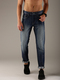

In [25]:
result_images[9]

In [26]:
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode


def display_search_results(result_images: list[Any]) -> HTML:
    """This is used to return the result of the search query.

    Params:
    -------
        result_images (list[Any]): List containing the results of the images from the search query.

    Returns:
    --------
        html_images (str): The html formatted images from the search query results.
    """
    figures: list[Any] = []
    html_str: str = """
            <figure style="margin: 8px !important;">
                <img src="data: image/png;base64,{}" style="width: 90px; height: 120px" >
            </figure>
    """

    for img in result_images:
        b = BytesIO()
        img.save(b, format="png")
        figures.append(html_str.format(b64encode(b.getvalue()).decode("utf-8")))

    html_images: str = HTML(
        data=f"""
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    """
    )

    return html_images

In [27]:
display_search_results(result_images)

In [28]:
for res in result.get("matches"):
    pprint(f'{res.get("metadata").get("productDetails")}')

'Men Apparel Bottomwear Jeans Blue Fall Casual John Players Men Blue Jeans'
('Men Apparel Bottomwear Jeans Navy Blue Summer Casual Lee Rinse Navy Blue '
 'Slim Fit Jeans')
'Men Apparel Topwear Tshirts Grey Spring Casual Probase Men Stripe Grey T-shirt'
'Men Apparel Bottomwear Jeans Blue Summer Casual Jack & Jones Men Blue Jeans'
('Men Apparel Bottomwear Jeans Blue Summer Casual Wrangler Men Blue Skanders '
 'Jeans')
('Men Apparel Bottomwear Jeans Blue Summer Casual French Connection Men Blue '
 'Jeans')
('Men Apparel Bottomwear Jeans Navy Blue Spring Casual Wrangler Men Navy Blue '
 'Floyd Jeans')
'Men Apparel Bottomwear Jeans Blue Summer Casual John Players Men Blue Jeans'
'Men Apparel Bottomwear Jeans Blue Fall Casual Locomotive Men Banks Blue Jeans'
('Men Apparel Bottomwear Jeans Blue Winter Casual Flying Machine Men Blue Slim '
 'Fit Mid-Rise Clean Look Jeans')


In [29]:
N: int = 16
query: str = "ripped denim for men"

# Create sparse and dense vectors
sparse_vector: dict[str, Any] = bm25.encode_queries(texts=query)
dense_vector: list[float] = model.encode(sentences=query).tolist()

result = index.query(
    vector=dense_vector, sparse_vector=sparse_vector, include_metadata=True, top_k=N
)
result_images: list[Any] = [images[int(res.get("id"))] for res in result.get("matches")]

display_search_results(result_images)

In [30]:
for res in result.get("matches"):
    pprint(f'{res.get("metadata").get("productDetails")}')

('Men Apparel Bottomwear Jeans Blue Winter Casual Flying Machine Men Blue Slim '
 'Fit Mid-Rise Clean Look Jeans')
('Men Apparel Bottomwear Jeans Navy Blue Spring Casual Wrangler Men Navy Blue '
 'Floyd Jeans')
('Men Apparel Bottomwear Jeans Blue Fall Casual SPYKAR Men Slim Fit Free '
 'Republic Wheeler Spirit Blue Jeans')
('Men Apparel Bottomwear Jeans Blue Summer Casual Wrangler Men Blue Skanders '
 'Jeans')
('Women Apparel Bottomwear Jeans Blue Fall Casual Spykar Women Ep Jeans Blue '
 'Jeans')
('Men Apparel Bottomwear Jeans Blue Summer Casual French Connection Men Blue '
 'Jeans')
('Men Apparel Bottomwear Jeans Navy Blue Summer Casual French Connection Navy '
 'Washed Skinny Stretchable Jeans')
('Women Apparel Bottomwear Jeans Blue Summer Casual Lee Women Scraped Blue '
 'Roxy Fit Jeans')
'Men Apparel Bottomwear Jeans Blue Fall Casual Deniyo Men Washed Blue Jeans'
'Men Apparel Bottomwear Jeans Blue Summer Casual Spykar Men Blue Jeans'
('Men Apparel Bottomwear Jeans Blue Summer Casu

In [31]:
N: int = 16
query: str = "comfy red unisex flip flop"

# Create sparse and dense vectors
sparse_vector: dict[str, Any] = bm25.encode_queries(texts=query)
dense_vector: list[float] = model.encode(sentences=query).tolist()

result = index.query(
    vector=dense_vector, sparse_vector=sparse_vector, include_metadata=True, top_k=N
)
result_images: list[Any] = [images[int(res.get("id"))] for res in result.get("matches")]

display_search_results(result_images)

In [32]:
for res in result.get("matches"):
    pprint(f'{res.get("metadata").get("productDetails")}')

("Women Footwear Flip Flops Flip Flops Black Summer Casual Lotto Women's Flora "
 'Black Red Flip Flop')
("Men Footwear Flip Flops Flip Flops Red Summer Casual Numero Uno Men's Casual "
 'Graphic Red Flip Flop')
('Unisex Footwear Sandal Sandals Red Fall Casual Warner Bros Kids Unisex TJ '
 'Hit & Chase Flops Red Slippers')
('Women Footwear Flip Flops Flip Flops Red Fall Casual ADIDAS Women Striped '
 'Red Flip Flops')
('Women Footwear Flip Flops Flip Flops Red Winter Casual Roxy Women Red Flip '
 'Flops')
('Unisex Footwear Flip Flops Flip Flops Red Summer Casual Puma Unisex Tropi '
 'Cat Red White Flip Flop')
('Men Footwear Flip Flops Flip Flops Red Fall Casual Calvin Klein Men Red Flip '
 'Flops')
('Men Footwear Flip Flops Flip Flops Red Spring Casual ADIDAS Men Adi Linear '
 'Red Slippers')
('Unisex Footwear Flip Flops Flip Flops Red Fall Casual Warner Bros Kids '
 'Unisex SD Safari Flop Red Slippers')
('Unisex Footwear Flip Flops Flip Flops Red Fall Casual Warner Bros Kids '
 'Unise

## Implement Hybrid Search

- Scale the dense and sparse vector. i.e. use a combination of the vectors.

In [33]:
def scale_vectors(
    dense_vector: list[float], sparse_vector: dict[str, Any], alpha: float
) -> tuple[list[float], dict[str, Any]]:
    """This returns the a scaled combination of the dense and sparse vectors.

    Params:
    -------
        dense_vector (list[float]): The dense vectors.
        sparse_vector (dict[str, Any]): The sparse vectors.
        alpha (float): Float between 0 and 1 where `0 == sparse` only
                        and `1 == dense` only.

    Returns:
    --------
        result_vectors (tuple[dense_vector,sparse_vector]): Tuple containing the dense and sparse vectors.
    """
    if not 0 <= alpha <= 1:
        raise ValueError("Alpha must be a value between 0 and 1.")

    _sparse: dict[str, Any] = {
        "indices": sparse_vector.get("indices"),
        "values": [vec * (1 - alpha) for vec in sparse_vector.get("values")],
    }
    _dense: list[float] = [vec * alpha for vec in dense_vector]
    result: tuple[list[float], dict[str, Any]] = (_dense, _sparse)

    return result

#### Use Dense Only

- alpha = 1

In [34]:
N: int = 10
query: str = "beige winter formal dress for women"

# Create sparse and dense vectors
sparse_vector: dict[str, Any] = bm25.encode_queries(texts=query)
dense_vector: list[float] = model.encode(sentences=query).tolist()

dense_vector, sparse_vector = scale_vectors(
    dense_vector=dense_vector, sparse_vector=sparse_vector, alpha=1
)
result = index.query(
    vector=dense_vector, sparse_vector=sparse_vector, include_metadata=True, top_k=N
)
result_images: list[Any] = [images[int(res.get("id"))] for res in result.get("matches")]

display_search_results(result_images)

In [35]:
for res in result.get("matches"):
    pprint(f'{res.get("metadata").get("productDetails")}')

('Women Apparel Loungewear and Nightwear Nightdress Beige Summer Casual Enamor '
 'Women Beige Nightdress')
('Women Apparel Topwear Kurtas Brown Fall Ethnic Mother Earth Women Brown '
 'Printed Kurta')
('Women Apparel Loungewear and Nightwear Nightdress Brown Summer Casual Enamor '
 'Women Brown Nightdress')
'Women Apparel Topwear Kurtas Cream Summer Ethnic Diva Women Cream Kurta'
('Women Apparel Topwear Kurtas Brown Fall Ethnic Vishudh Women Brown Printed '
 'Kurta')
'Women Apparel Dress Dresses Gold Summer Casual Tonga Women Gold Dress'
'Women Apparel Dress Dresses Orange Fall Casual Femella Women Orange Dress'
('Women Apparel Loungewear and Nightwear Nightdress Pink Summer Casual Bwitch '
 'Women Pink Nightdress')
('Women Apparel Topwear Sweaters White Fall Casual Scullers Women Knit White '
 'Sweaters')
('Women Apparel Topwear Kurtas Brown Fall Ethnic Vishudh Women Printed Brown '
 'Kurta')


<hr>

### [Google Search Results](https://www.google.com/search?q=beige+winter+formal+dress+for+women&oq=beige+winter+formal+dress+for+women&gs_lcrp=EgZjaHJvbWUyBggAEEUYOdIBBzQxMmowajmoAgCwAgA&sourceid=chrome&ie=UTF-8)

[![image.png](https://i.postimg.cc/B605jhsr/image.png)](https://postimg.cc/3yt06Fk1)

<hr>

#### Use Sparse Only

- alpha = 0

In [36]:
N: int = 10
query: str = "beige winter formal dress for women"

# Create sparse and dense vectors
sparse_vector: dict[str, Any] = bm25.encode_queries(texts=query)
dense_vector: list[float] = model.encode(sentences=query).tolist()

dense_vector, sparse_vector = scale_vectors(
    dense_vector=dense_vector, sparse_vector=sparse_vector, alpha=0
)
result = index.query(
    vector=dense_vector, sparse_vector=sparse_vector, include_metadata=True, top_k=N
)
result_images: list[Any] = [images[int(res.get("id"))] for res in result.get("matches")]

display_search_results(result_images)

In [37]:
for res in result.get("matches"):
    pprint(f'{res.get("metadata").get("productDetails")}')

('Women Apparel Dress Dresses Beige Winter Casual French Connection Women '
 'Beige Dress')
'Women Apparel Dress Dresses Beige Summer Casual Sepia Women Beige Dress'
'Women Apparel Dress Dresses Beige Summer Casual Tonga Women Beige Dress'
'Women Apparel Dress Dresses Beige Fall Casual Latin Quarters Women Beige Dress'
'Women Apparel Dress Dresses Beige Summer Casual Vero Moda Women Beige Dress'
('Women Apparel Dress Dresses Beige Fall Casual United Colors of Benetton '
 'Women Beige Printed Dress')
'Women Apparel Dress Dresses Black Fall Formal Avirate Black Formal Dress'
'Women Apparel Dress Dresses Beige Fall Casual Tonga Brown Animal Print Dress'
'Women Apparel Dress Dresses Beige Fall Casual Tonga Brown Animal Print Dress'
'Women Footwear Shoes Heels Beige Winter Formal Rocia Women Beige Wedges'


### Use Combination of Dense and Sparse Vectors

- alpha = 0.8 (Mostly dense)

In [38]:
N: int = 10
query: str = "beige winter formal dress for women"

# Create sparse and dense vectors
sparse_vector: dict[str, Any] = bm25.encode_queries(texts=query)
dense_vector: list[float] = model.encode(sentences=query).tolist()

dense_vector, sparse_vector = scale_vectors(
    dense_vector=dense_vector, sparse_vector=sparse_vector, alpha=0.8
)
result = index.query(
    vector=dense_vector, sparse_vector=sparse_vector, include_metadata=True, top_k=N
)
result_images: list[Any] = [images[int(res.get("id"))] for res in result.get("matches")]

display_search_results(result_images)

In [39]:
for res in result.get("matches"):
    pprint(f'{res.get("metadata").get("productDetails")}')

('Women Apparel Loungewear and Nightwear Nightdress Beige Summer Casual Enamor '
 'Women Beige Nightdress')
('Women Apparel Topwear Kurtas Brown Fall Ethnic Mother Earth Women Brown '
 'Printed Kurta')
('Women Apparel Loungewear and Nightwear Nightdress Brown Summer Casual Enamor '
 'Women Brown Nightdress')
'Women Apparel Topwear Kurtas Cream Summer Ethnic Diva Women Cream Kurta'
('Women Apparel Topwear Kurtas Brown Fall Ethnic Vishudh Women Brown Printed '
 'Kurta')
'Women Apparel Dress Dresses Gold Summer Casual Tonga Women Gold Dress'
'Women Apparel Dress Dresses Orange Fall Casual Femella Women Orange Dress'
('Women Apparel Loungewear and Nightwear Nightdress Pink Summer Casual Bwitch '
 'Women Pink Nightdress')
('Women Apparel Topwear Sweaters White Fall Casual Scullers Women Knit White '
 'Sweaters')
('Women Apparel Topwear Kurtas Brown Fall Ethnic Vishudh Women Printed Brown '
 'Kurta')


In [40]:
N: int = 10
query: str = "beige winter formal dress for women"

# Create sparse and dense vectors
sparse_vector: dict[str, Any] = bm25.encode_queries(texts=query)
dense_vector: list[float] = model.encode(sentences=query).tolist()

dense_vector, sparse_vector = scale_vectors(
    dense_vector=dense_vector, sparse_vector=sparse_vector, alpha=0.2
)
result = index.query(
    vector=dense_vector, sparse_vector=sparse_vector, include_metadata=True, top_k=N
)
result_images: list[Any] = [images[int(res.get("id"))] for res in result.get("matches")]

display_search_results(result_images)

In [41]:
for res in result.get("matches"):
    pprint(f'{res.get("metadata").get("productDetails")}')

('Women Apparel Loungewear and Nightwear Nightdress Beige Summer Casual Enamor '
 'Women Beige Nightdress')
'Women Apparel Dress Dresses Gold Summer Casual Tonga Women Gold Dress'
'Women Apparel Dress Dresses Orange Fall Casual Femella Women Orange Dress'
('Women Apparel Topwear Kurtas Brown Fall Ethnic Mother Earth Women Brown '
 'Printed Kurta')
('Women Apparel Loungewear and Nightwear Nightdress Brown Summer Casual Enamor '
 'Women Brown Nightdress')
'Women Apparel Topwear Kurtas Cream Summer Ethnic Diva Women Cream Kurta'
('Women Apparel Topwear Kurtas Brown Fall Ethnic Vishudh Women Brown Printed '
 'Kurta')
('Women Apparel Bottomwear Skirts Beige Fall Casual Forever New Women Clay '
 'Pleated Beige Skirts')
'Women Apparel Dress Dresses White Summer Casual Tonga Women White Dress'
('Women Apparel Loungewear and Nightwear Nightdress Pink Summer Casual Bwitch '
 'Women Pink Nightdress')


In [42]:
N: int = 10
query: str = "maroon casual bag for ladies"

# Create sparse and dense vectors
sparse_vector: dict[str, Any] = bm25.encode_queries(texts=query)
dense_vector: list[float] = model.encode(sentences=query).tolist()

dense_vector, sparse_vector = scale_vectors(
    dense_vector=dense_vector, sparse_vector=sparse_vector, alpha=0
)
result = index.query(
    vector=dense_vector, sparse_vector=sparse_vector, include_metadata=True, top_k=N
)
result_images: list[Any] = [images[int(res.get("id"))] for res in result.get("matches")]

display_search_results(result_images)

In [43]:
for res in result.get("matches"):
    pprint(f'{res.get("metadata").get("productDetails")}')

('Women Apparel Topwear Tops Maroon Fall Casual DUSG Women Peacock Ladies '
 'Organic Cotton Top')
('Unisex Accessories Bags Duffel Bag Maroon Fall Casual Skybags Unisex Maroon '
 'Duffle Bag')
'Women Accessories Bags Handbags Maroon Summer Casual Baggit Women Maroon Bag'
('Women Accessories Bags Handbags Maroon Winter Casual Lino Perros Maroon '
 'Women Casual Sling Bag')
('Women Accessories Bags Handbags Maroon Summer Casual Rocia Women Maroon '
 'Handbag')
('Women Accessories Bags Clutches Maroon Summer Casual Pitaraa Women Maroon '
 'Purse')
('Women Accessories Bags Handbags Maroon Summer Casual Kiara Women Maroon '
 'Handbag')
'Women Accessories Bags Clutches Maroon Summer Casual Baggit Women Maroon Purse'
('Women Accessories Bags Handbags Maroon Spring Casual Murcia Women Maroon '
 'Handbag')
'Women Accessories Bags Clutches Maroon Summer Casual Rocia Women Maroon Clutch'


In [44]:
N: int = 10
query: str = "maroon casual bag for ladies"

# Create sparse and dense vectors
sparse_vector: dict[str, Any] = bm25.encode_queries(texts=query)
dense_vector: list[float] = model.encode(sentences=query).tolist()

dense_vector, sparse_vector = scale_vectors(
    dense_vector=dense_vector, sparse_vector=sparse_vector, alpha=1
)
result = index.query(
    vector=dense_vector, sparse_vector=sparse_vector, include_metadata=True, top_k=N
)
result_images: list[Any] = [images[int(res.get("id"))] for res in result.get("matches")]

display_search_results(result_images)

In [45]:
for res in result.get("matches"):
    pprint(f'{res.get("metadata").get("productDetails")}')

'Women Accessories Bags Handbags Red Summer Casual Baggit Women Red Bag'
('Women Accessories Bags Handbags Purple Summer Casual Baggit Women Purple '
 'Handbag')
('Women Accessories Bags Handbags Maroon Summer Casual United Colors of '
 'Benetton Women Solid Maroon Handbags')
('Women Accessories Bags Handbags Red Winter Casual Baggit Women Red Selection '
 'Lisa Sling Bag')
'Women Accessories Bags Handbags Red Summer Casual Hidekraft Women Red Handbag'
('Women Accessories Bags Handbags Red Winter Casual Murcia Women Red '
 'Leatherite Handbag')
('Women Accessories Bags Handbags Maroon Winter Casual Murcia Women Casual '
 'Maroon Handbag')
('Women Accessories Bags Handbags Red Winter Casual Baggit Women Hoor Red '
 'Handbag')
('Women Accessories Bags Handbags Red Fall Casual Nike Women Graphic Play Red '
 'Bag')
'Women Accessories Bags Handbags Red Summer Casual Murcia Women Red Handbag'


<br>

### Add Filters

In [46]:
N: int = 10
query: str = "vests for gents"

# Create sparse and dense vectors
sparse_vector: dict[str, Any] = bm25.encode_queries(texts=query)
dense_vector: list[float] = model.encode(sentences=query).tolist()

dense_vector, sparse_vector = scale_vectors(
    dense_vector=dense_vector, sparse_vector=sparse_vector, alpha=0.7
)
result = index.query(
    vector=dense_vector,
    sparse_vector=sparse_vector,
    include_metadata=True,
    top_k=N,
    # filter={"baseColour": "Maroon"}
)
result_images: list[Any] = [images[int(res.get("id"))] for res in result.get("matches")]

display_search_results(result_images)

In [47]:
for res in result.get("matches"):
    pprint(f'{res.get("metadata").get("productDetails")}')

('Boys Apparel Topwear Waistcoat Grey Summer Casual United Colors of Benetton '
 'Boys Check Grey Waistcoat')
'Men Apparel Topwear Waistcoat Red Fall Casual Basics Men Red Checked Waistcoat'
'Men Apparel Topwear Sweaters Grey Fall Casual Spykar Men Stripes Grey Sweaters'
('Men Apparel Topwear Sweaters Black Fall Casual Proline Black Sleeveless '
 'Sweater')
'Men Apparel Topwear Sweaters Blue Fall Casual Puma Men Solid Blue Sweater'
('Men Apparel Topwear Sweaters Grey Fall Casual Puma Men Stripped SL Grey '
 'Sweater')
('Men Apparel Topwear Sweaters Black Fall Casual Spykar Men Stripes Black '
 'Sweaters')
('Men Apparel Topwear Sweaters Black Fall Casual Spykar Men Rts Vneck Black '
 'Black Sweaters')
('Men Apparel Topwear Waistcoat Brown Fall Casual Basics Men Brown Checked '
 'Waistcoat')
('Men Apparel Innerwear Innerwear Vests Grey Melange Summer Casual Crusoe Men '
 'Square Neck Tee Grey Melange Innerwear Vest')
